# Heat dissipation in SOI platforms

When designing heated devices, it is important to have an understanding of thermal crosstalk in order to inform the spatial layout of your device. In this example we study the effects on silicon waveguides from heating elements spaced at various distances. This is based on the simulation and experimental data specified in `Pant et. al. "Study into the spread of heat from thermo-optic silicon photonic elements," Opt. Express 29, 36461-36468 (2021)` [DOI:10.1364/OE.426748](https://doi.org/10.1364/OE.426748).<br><br>
In this paper, the authors study the thermal crosstalk between heating elements and waveguides, as well as heated waveguides and reference waveguides, separated at various distances. Here we replicate results of two setups:<br>
<ol>
<li>A heating element at a fixed height above a reference silicon waveguide, translated laterally at various distances. We record the temperature in the center of the waveguide at these heater distances.</li>
<li>A heating element above a silicon waveguide, both translated laterally from a reference waveguide. We record the temperature profile along the cross-section through the center of the waveguide layer.</li>
</ol>
<img src="img/heat_dissipation_SOI.png" width="500" alt="Schematic of heating SOI setup">
In both setups, we use the stack in process design kit (PDK) of the Cornerstone multi-project wafer (MPW) fabrication service: Silicon on a buried oxide layer, with $\text{SiO}_2$ cladding, with a separation of 5 μm between the waveguide and surrounding silicon, all on a silicon substrate.

In [1]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Make Structures

The waveguide in the first setup in the paper is meant to be the arm of a Mach-Zehnder interferometer (MZI). We will thus distinguish this waveguide from the next by labelling it as "arm." We will also define the layer thicknesses used in the paper's PDK.

In [2]:
# waveguide geometry
arm_thickness = 0.22
arm_width = 0.5

# heating element geometry
heat_thickness = 0.15
heat_length = 108
heat_width = 2
heat_height = 1

# for defining different heaters, the difference which we'll analyze
heat_offsets = np.linspace(0, 10, 11)

# other layer information
oxide_bottom_thickness = 2
oxide_top_thickness = 1

inf = 1000  # large number for making structures extend effectively to infinity

In [3]:
# create geometries
arm_geo = td.Box(size=(heat_length, arm_width, arm_thickness))

heat_geo = td.Box(
    center=(0, 0, heat_height + heat_thickness / 2), size=(heat_length, heat_width, heat_thickness)
)
# translate copies of each heater along their corresponding distance
heat_geos = [heat_geo]
for i in range(len(heat_offsets) - 1):
    dif = heat_offsets[i] - heat_offsets[i + 1]
    heat_geos.append(heat_geos[i].translated(x=0, y=dif, z=0))

oxide_geo = td.Box.from_bounds(
    rmin=(-inf, -inf, -2 - arm_thickness / 2), rmax=(inf, inf, heat_height)
)

si_bottom_geo = td.Box.from_bounds(rmin=(-inf, -inf, -inf), rmax=(inf, inf, -2 - arm_thickness / 2))

## Define Multiphysics Materials

Since we are interested in thermal properties of these materials, we must define perturbation mediums to track this information.

In [4]:
freq0 = td.C_0 / 1.55

# material properties
Si_n = 3.4777  # Si refraction index
Si_dn_dT = 1.86e-4  # Si thermo-optic coefficient dn/dT, 1/K
Si_s = 711  # Si specific heat, J / (kg * K)
Si_k = 148e-6  # Si thermal conductivity, W / (um * K)

SiO2_n = 1.444  # SiO2 refraction index
SiO2_dn_dT = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K
SiO2_s = 700  # SiO2 specific heat capacity, J / (kg * K)
SiO2_k = 1.38e-6  # SiO2 thermal conductivity, W/(um*K)

TiN_s = 598  # TiN specific heat capacity, J / (kg * K)
TiN_k = 28e-6  # TiN thermal conductivity W/(um*K)

Si = td.PerturbationMedium(
    permittivity=Si_n**2,
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=Si_dn_dT, temperature_ref=300)
        ),
        freq=freq0,
    ),
    heat_spec=td.SolidSpec(
        conductivity=Si_k,
        capacity=Si_s,
    ),
    name="Si",
)

SiO2 = td.PerturbationMedium(
    permittivity=SiO2_n**2,
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=SiO2_dn_dT, temperature_ref=300)
        ),
        freq=freq0,
    ),
    heat_spec=td.SolidSpec(
        conductivity=SiO2_k,
        capacity=SiO2_s,
    ),
    name="SiO2",
)

TiN = td.PECMedium(
    heat_spec=td.SolidSpec(
        conductivity=TiN_k,
        capacity=TiN_s,
    ),
    name="TiN",
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

## Create Structures and Combine Them into a Scene

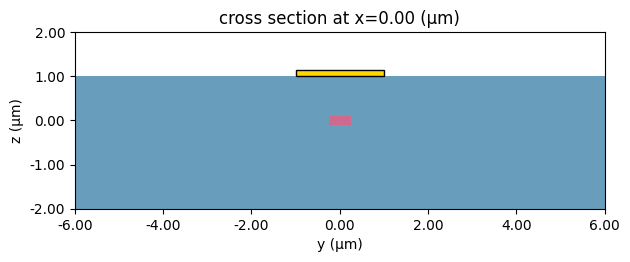

In [5]:
oxide = td.Structure(geometry=oxide_geo, medium=SiO2, name="BOX")
arm = td.Structure(geometry=arm_geo, medium=Si, name="MZI")
heaters = [
    td.Structure(geometry=heat_geo, medium=TiN, name=str(i)) for i, heat_geo in enumerate(heat_geos)
]
si_bottom = td.Structure(geometry=si_bottom_geo, medium=Si, name="Si_bottom")

scene = td.Scene(
    medium=air,
    structures=[oxide, arm, heaters[0]],
)
scene.plot(x=0, hlim=(-6, 6), vlim=(-2, 2))
plt.show()

## Other Heat Simulation Specifications

Here we define the heat source and assign it to the heating element structure:

In [6]:
heater_volume = heat_thickness * heat_width * heat_length

heat_watts = 13e-3  # heat given in paper as 13 mW
heat_rate = heat_watts / heater_volume
heat_sources = [td.HeatSource(rate=heat_rate, structures=[heater.name]) for heater in heaters]

In the paper, the temperature is measured in the center of the waveguide, so we define a point temperature monitor at this location:

In [7]:
temp = td.TemperatureMonitor(size=(0, 0, 0), name="t", unstructured=True, conformal=True)

In the paper, the bottom boundary of the simulation is kept at 300 °K, so we implement this boundary condition:

In [8]:
bc_bottom = td.HeatBoundarySpec(
    placement=td.SimulationBoundary(surfaces=["z-"]),
    condition=td.TemperatureBC(temperature=300),
)

Here we define the unstructured meshing used in the heat simulation subject to the thickness of the thinnest structure (the heating element) in the simulation:

In [9]:
dl_min = heat_thickness / 3
grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=4 * dl_min,
    distance_interface=3 * dl_min,
    distance_bulk=2 * heat_height,
)

## Create Batch of Heat Simulations

Note that, for the first simulation with zero offset, the simulation has symmetry, so we will add this into the first simulation.

In [10]:
def create_sim(heat_index, symmetry):
    heat_sim = td.HeatChargeSimulation(
        size=(0, 6 + heat_index * heat_width, 6),
        boundary_spec=[bc_bottom],
        structures=[oxide, arm, heaters[heat_index], si_bottom],
        sources=[heat_sources[heat_index]],
        monitors=[temp],
        symmetry=symmetry,
        grid_spec=grid_spec,
        medium=air,
    )
    return heat_sim

In [11]:
heat_sims_1 = {}
for i in range(len(heat_sources)):
    symmetry = (0, 0, 0)
    if i == 0:
        symmetry = (0, 1, 0)
    heat_sims_1[str(i)] = create_sim(i, symmetry)

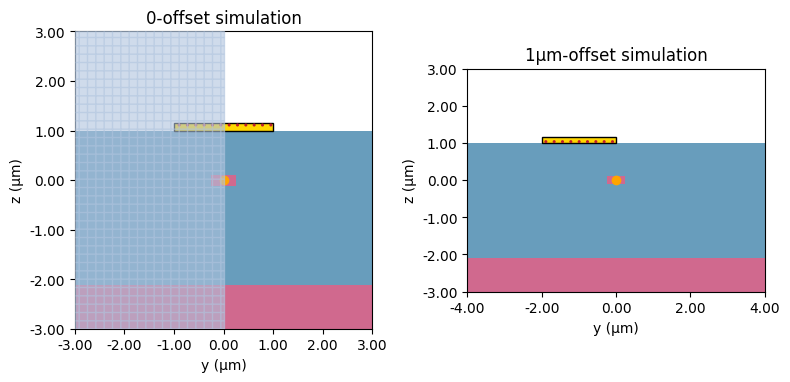

In [12]:
# check simulations
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 6))

heat_sims_1["0"].plot(x=0, ax=ax[0])
ax[0].set_title("0-offset simulation")
heat_sims_1["1"].plot(x=0, ax=ax[1])
ax[1].set_title("1μm-offset simulation")
plt.show()

## Run Batch

In [13]:
batch_1 = web.Batch(simulations=heat_sims_1)
batch_1_data = batch_1.run(path_dir="./heat_data/")

Output()

17:44:05 -03 Started working on Batch containing 11 tasks.

17:44:17 -03 Maximum FlexCredit cost: 0.275 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:45:02 -03 Batch complete.

Output()

## Get and Compare Data

We compare the temperatures in the center of the waveguide for each simulation with the paper's experimental ("Experiment") and simulated ("Alternative simulation") data:

In [14]:
temps_1 = np.squeeze(
    [(batch_1_data[str(i)]["t"].temperature - 300) for i in range(len(heat_sources))]
)

17:45:14 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:16 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:18 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:20 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:22 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:24 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:27 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:29 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:31 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:33 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:45:35 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

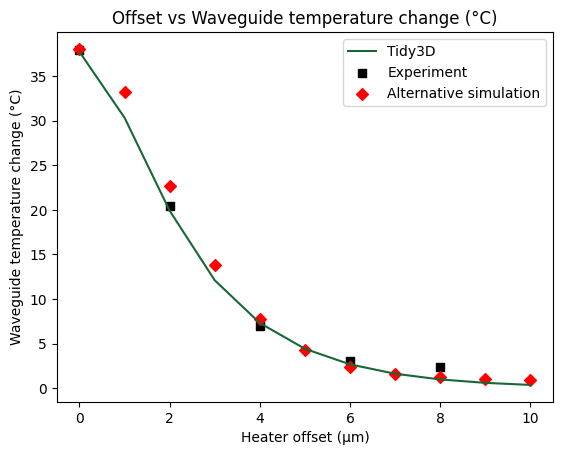

In [15]:
# data from Pant et. al. (their simulations and experiment)
experimental_data = [37.9, 20.48213, 6.93489, 3.06426, 2.33851]
exp_domain = heat_offsets[:-1:2]
paper_sim_data = [38.05, 33.22, 22.67, 13.77, 7.79, 4.22, 2.35, 1.54, 1.23, 1.06, 0.92]

plt.plot(heat_offsets, temps_1, label="Tidy3D")
plt.scatter(exp_domain, experimental_data, label="Experiment", marker="s", color="black")
plt.scatter(heat_offsets, paper_sim_data, label="Alternative simulation", marker="D", color="red")
plt.legend()
plt.title("Offset vs Waveguide temperature change (°C)")
plt.xlabel("Heater offset (μm)")
plt.ylabel("Waveguide temperature change (°C)")
plt.show()

## Second Setup: Heated Waveguide & Reference Waveguide

Here we compare the heat in the center of a reference waveguide due to a heated waveguide translated various distances from the reference waveguide, with the PDK's requirement of 5 μm spacing between waveguides and surrounding silicon. Pant et. al. considered 3 different sets of layer thicknesses.

In [16]:
# create a function that gives the stack with waveguides given their spacing and layer thicknesses
wg_width = 0.5

# define heater source
heat_rate = 16e-3 / heat_thickness / heat_width / heat_length
# in the below function we will ensure our heater structure has the name "heater"
heat_source = td.HeatSource(rate=heat_rate, structures=["heater"])

# Add same boundary conditions
bc_bottom = td.HeatBoundarySpec(
    placement=td.SimulationBoundary(surfaces=["z-"]),
    condition=td.TemperatureBC(temperature=300),
)


def make_stack(dS, si_thick, box_thick, top_thick):
    # define stack geometry
    inf = 1000
    si_spacing = 5
    heat_thickness = 0.15
    heat_width = 2

    # define silicon waveguide and surrounding silicon geometries based on separation distances
    si_geos = [
        td.Box(center=(-dS / 2, 0, 0), size=(wg_width, inf, si_thick)),
        td.Box.from_bounds(
            rmin=((dS + wg_width) / 2 + si_spacing, 0, -si_thick / 2), rmax=(inf, inf, si_thick / 2)
        ),
    ]
    geo_group_R = td.GeometryGroup(geometries=si_geos)
    geo_group = [geo_group_R.rotated(np.pi, axis=1), geo_group_R]
    if dS > 2 * si_spacing + wg_width:
        geo_group.append(td.Box(size=(dS - wg_width - 2 * si_spacing, inf, si_thick)))
    si_geo = td.GeometryGroup(geometries=geo_group)

    # geometry of the buried oxide layer
    oxide_geo = td.Box.from_bounds(
        rmin=(-inf, -inf, -si_thick / 2 - box_thick), rmax=(inf, inf, si_thick / 2 + top_thick)
    )

    # geometry of the silicon substrate
    si_bottom_geo = td.Box.from_bounds(
        rmin=(-inf, -inf, -inf), rmax=(inf, inf, si_thick / 2 - box_thick)
    )

    # geometry of the heating element
    heat_geo = td.Box(
        center=(-dS / 2, 0, si_thick / 2 + top_thick + heat_thickness / 2),
        size=(heat_width, heat_length, heat_thickness),
    )

    # add materials to corresponding layer geometries
    si = td.Structure(geometry=si_geo.translated(x=-dS / 2, y=0, z=0), medium=Si, name="si")
    oxide = td.Structure(geometry=oxide_geo, medium=SiO2, name="oxide")
    si_bottom = td.Structure(geometry=si_bottom_geo, medium=Si, name="si bottom")
    heater = td.Structure(
        geometry=heat_geo.translated(x=-dS / 2, y=0, z=0), medium=TiN, name="heater"
    )

    # Add mesh
    dl_min = heat_thickness / 3
    grid_spec = td.DistanceUnstructuredGrid(
        dl_interface=dl_min,
        dl_bulk=4 * dl_min,
        distance_interface=3 * dl_min,
        distance_bulk=2 * top_thick,
    )

    # add symmetry if there is no offset (the reference and heated waveguide are the same)
    symmetry = (0, 0, 0)
    if dS == 0:
        symmetry = (1, 0, 0)

    # record temperature at cross-section through the waveguide's center
    sim_center_x = -5
    if dS == 0:
        sim_center_x = 0
    sim_size_x = 40
    line_monitor = td.TemperatureMonitor(
        center=(sim_center_x, 0, 0),
        size=(sim_size_x, 0, 0),
        name="temp_line_profile",
        unstructured=True,
        conformal=True,
    )

    # create corresponding heat simulation
    sim_padding_z = 1
    sim = td.HeatChargeSimulation(
        center=(sim_center_x, 0, 0),
        size=(sim_size_x, 0, si_thick + box_thick + top_thick + 2 * sim_padding_z),
        medium=air,
        structures=[si_bottom, oxide, si, heater],
        sources=[heat_source],
        boundary_spec=[bc_bottom],
        monitors=[line_monitor],
        grid_spec=grid_spec,
        symmetry=symmetry,
    )
    return sim

## Create Batch

Here we create a batch of heat simulations for each set of stack thicknesses with each distance between heated and reference waveguides.

In [17]:
dSs = [0, 3, 6, 9]
si_thicknesses = [[0.22, 2, 1], [0.34, 2, 1], [0.5, 3, 2]]

SOIs = {}
for si_profile in si_thicknesses:
    for dS in dSs:
        SOIs[f"{si_profile[0]}-{dS}"] = make_stack(dS, si_profile[0], si_profile[1], si_profile[2])

Check simulations:

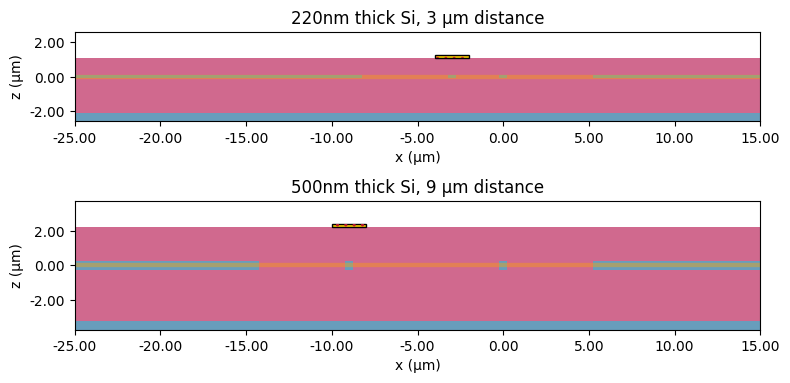

In [18]:
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(8, 4))

SOIs["0.22-3"].plot(y=0, ax=ax[0])
ax[0].set_title("220nm thick Si, 3 μm distance")
SOIs["0.5-9"].plot(y=0, ax=ax[1])
ax[1].set_title("500nm thick Si, 9 μm distance")
plt.show()

In [19]:
batch_2 = web.Batch(simulations=SOIs)
batch_2_data = batch_2.run(path_dir="./heat_data/")

Output()

17:45:41 -03 Started working on Batch containing 12 tasks.

17:45:54 -03 Maximum FlexCredit cost: 0.300 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:46:44 -03 Batch complete.

Output()

## Plot and Compare Data

Here we compare our simulation data with the data stored in Dataset 4 from Pant et. al. (This data is available in the linked paper, displayed in figures 8a and 8b). Tidy3D achieves a very accurate alignment with these results. This data captures the discontinuity in medium between the reference waveguide and the cladding near $x=0$. Due to the large number of data points rendered from Pant et. al., we plotted every fifth point so as not to overcrowd the plot with the plotting markers.

18:09:47 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

18:09:49 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

18:09:51 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

18:09:53 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

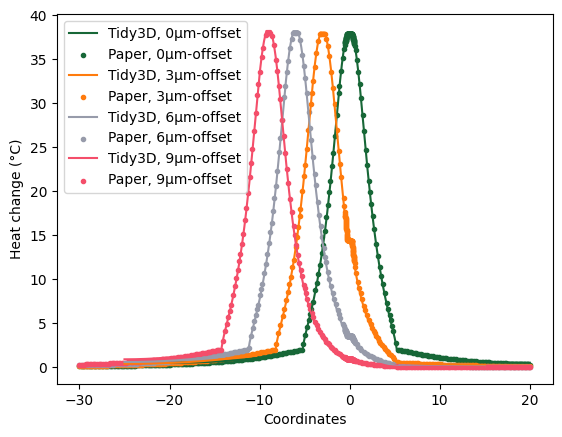

In [22]:
import pandas as pd

paper_data = pd.read_excel("misc/heat_dissipation_SOI.xlsx")

fig, ax = plt.subplots()
for dS in dSs:
    SOI_data = np.squeeze(batch_2_data[f"0.22-{dS}"]["temp_line_profile"].temperature - 300)
    (line,) = plt.plot(SOI_data.x, SOI_data, label="Tidy3D, " + str(dS) + "μm-offset")
    coords = paper_data[f"Distance (um) {dS}um separation"]
    temps = paper_data[f"Temp. Change (°C) {dS}um separation"]
    plt.scatter(
        coords[::5] * 1e6,
        temps[::5],
        label="Paper, " + str(dS) + "μm-offset",
        marker=".",
        color=line.get_color(),
    )
plt.legend()
plt.xlabel("Coordinates")
plt.ylabel("Heat change (°C)")
plt.show()

Here we plot the percent temperature change between the center of the heated waveguide and the center of the reference waveguide. Using the above data, we can replicate a portion of the data in Figure 8b in Pant et. al.

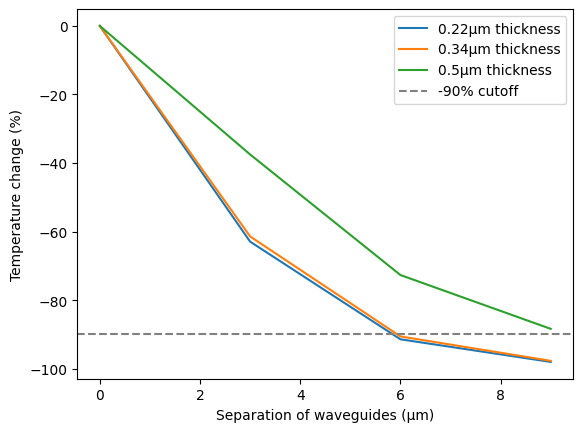

In [ ]:
fig, ax = plt.subplots()
for si_thickness in si_thicknesses:
    thickness_plot = []
    paper_plot = []
    for dS in dSs:
        temp_data = batch_2_data[f"{si_thickness[0]}-{dS}"]["temp_line_profile"].temperature
        t_ref = np.squeeze(temp_data.sel(x=0, method="nearest") - 300)
        t_heat = np.squeeze(temp_data.sel(x=-dS, method="nearest") - 300)
        thickness_plot.append((t_ref - t_heat) / t_heat * 100)
    plt.plot(dSs, thickness_plot, label=str(si_thickness[0]) + "μm thickness")
plt.axhline(y=-90, color="gray", linestyle="--", label="-90% cutoff")
plt.xlabel("Separation of waveguides (μm)")
plt.ylabel("Temperature change (%)")
plt.legend()
plt.show()

## Conclusion

In this notebook, we achieved close correspondence between published experimental and alternatively simulated thermal crosstalk data, ensuring Tidy3D Heat as an effective tool for determining the effects of heating in photonic devices.